<a href="https://colab.research.google.com/github/harishkumarsenthil/Fly-with-code/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import os

In [5]:
# Load individual datasets separately (they have different schemas)
listings = pd.read_csv(r'/content/drive/MyDrive/Harish_Intern/Harish_Intern/Boston Airbnb Open Data/listings.csv')
reviews = pd.read_csv(r'/content/drive/MyDrive/Harish_Intern/Harish_Intern/Boston Airbnb Open Data/reviews.csv')
calendar = pd.read_csv(r'/content/drive/MyDrive/Harish_Intern/Harish_Intern/Boston Airbnb Open Data/calendar.csv')

# Quick inspections
print('listings:', listings.shape)
print('reviews:', reviews.shape)
print('calendar:', calendar.shape)

# Save a combined CSV only after proper merges/aggregations if needed. For now keep files separate.
# Example: aggregate reviews per listing (number of reviews, avg rating if available)
reviews_agg = reviews.groupby('listing_id').agg({'id':'count'}).rename(columns={'id':'num_reviews'})

# Merge listings with aggregated reviews (left join on listing id column name in listings)
if 'id' in listings.columns:
    listings = listings.rename(columns={'id':'listing_id'})
merged = listings.merge(reviews_agg, how='left', left_on='listing_id', right_index=True)
merged['num_reviews'] = merged['num_reviews'].fillna(0).astype(int)

# Save merged snapshot
output_dir = r'/content/drive/MyDrive/Harish_Intern/Boston Airbnb Open Data'
os.makedirs(output_dir, exist_ok=True)
merged.to_csv(os.path.join(output_dir, 'merged_listings.csv'), index=False)
print('merged saved, shape:', merged.shape)

listings: (3585, 95)
reviews: (68275, 6)
calendar: (1308890, 4)
merged saved, shape: (3585, 96)


In [6]:
main = pd.read_csv('/content/drive/MyDrive/Harish_Intern/Harish_Intern/Boston Airbnb Open Data/combined_data.csv')

/tmp/ipython-input-1552090452.py:1: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,34,35,36,37,38,39,41,42,43,44,45,46,47,50,51,52,57,58,60,61,62,63,64,66,69,75,77,78,86,89,90,91,92,98,99,100) have mixed types. Specify dtype option on import or set low_memory=False.
  main = pd.read_csv('/content/drive/MyDrive/Harish_Intern/Harish_Intern/Boston Airbnb Open Data/combined_data.csv')


In [7]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380750 entries, 0 to 1380749
Columns: 101 entries, id to available
dtypes: float64(35), object(66)
memory usage: 1.0+ GB


In [8]:
# Visualization libraries and plotting defaults
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', rc={'figure.figsize':(10,6)})

In [9]:
# Data cleaning and EDA skeleton
import numpy as np
# Read the merged snapshot we created earlier (or read listings directly)
import os
merged_path = r'/content/drive/MyDrive/Harish_Intern/Boston Airbnb Open Data/merged_listings.csv'
df = pd.read_csv(merged_path)


# Clean price-like columns (remove $ and commas) if present
def clean_price(col):
    if col in df.columns:
        return df[col].astype(str).str.replace('\\$', '', regex=True).str.replace(',', '', regex=True)
    return None

if 'price' in df.columns:
    df['price'] = clean_price('price').replace('nan', np.nan).astype(float)

# Convert date columns in calendar if available
calendar_path = r'/content/drive/MyDrive/Harish_Intern/Boston Airbnb Open Data/calendar.csv'
if os.path.exists(calendar_path):
    cal = pd.read_csv(calendar_path)
    if 'date' in cal.columns:
        cal['date'] = pd.to_datetime(cal['date'], errors='coerce')
        cal['available'] = cal['available'].map({'t':True,'f':False, True:True, False:False})
        # Example availability by month for a sample listing
        cal_sample = cal.copy()
        cal_sample['month'] = cal_sample['date'].dt.to_period('M')




# Save cleaned dataset snapshot
cleaned_path = r'/content/drive/MyDrive/Harish_Intern/Boston Airbnb Open Data/cleaned_listings.csv'
df.to_csv(cleaned_path, index=False)
print('Cleaned data saved to', cleaned_path)

Cleaned data saved to /content/drive/MyDrive/Harish_Intern/Boston Airbnb Open Data/cleaned_listings.csv


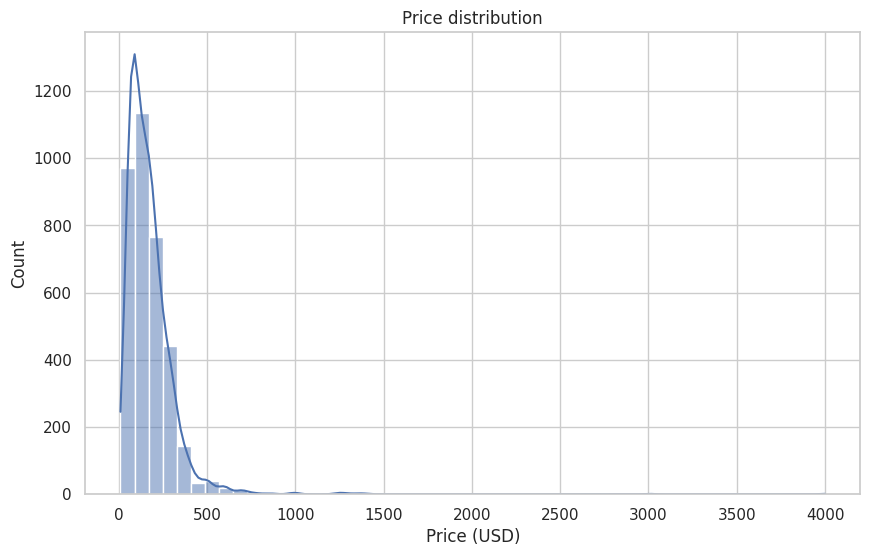

In [10]:

# Basic plots
plt.figure()
if 'price' in df.columns:
    sns.histplot(df['price'].dropna(), bins=50, kde=True)
    plt.title('Price distribution')
    plt.xlabel('Price (USD)')
    plt.show()


/tmp/ipython-input-3406204940.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_nb.values, y=top_nb.index, palette='viridis')


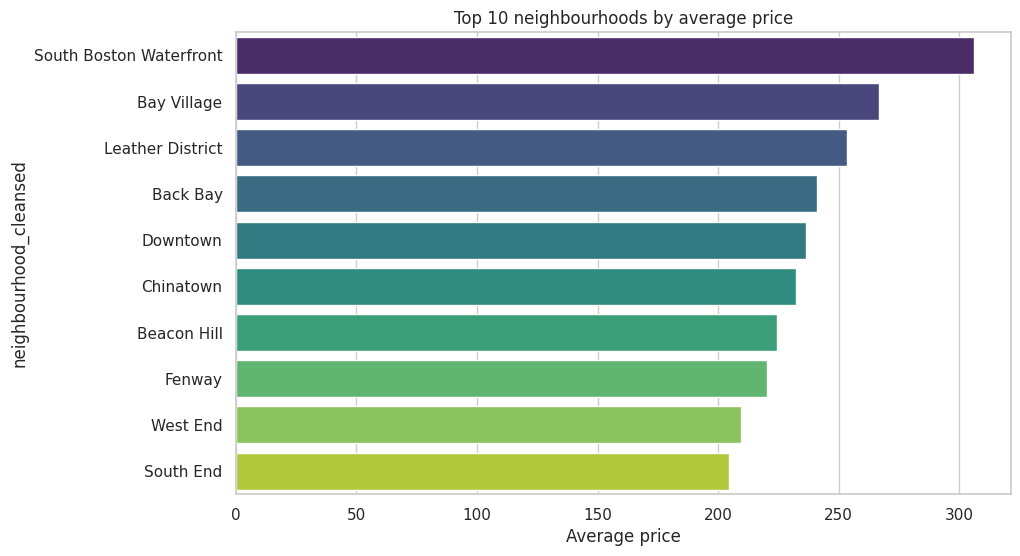

In [11]:
# Top neighborhoods by average price
if 'neighbourhood_cleansed' in df.columns and 'price' in df.columns:
    top_nb = df.groupby('neighbourhood_cleansed')['price'].mean().dropna().sort_values(ascending=False).head(10)
    plt.figure()
    sns.barplot(x=top_nb.values, y=top_nb.index, palette='viridis')
    plt.xlabel('Average price')
    plt.title('Top 10 neighbourhoods by average price')
    plt.show()


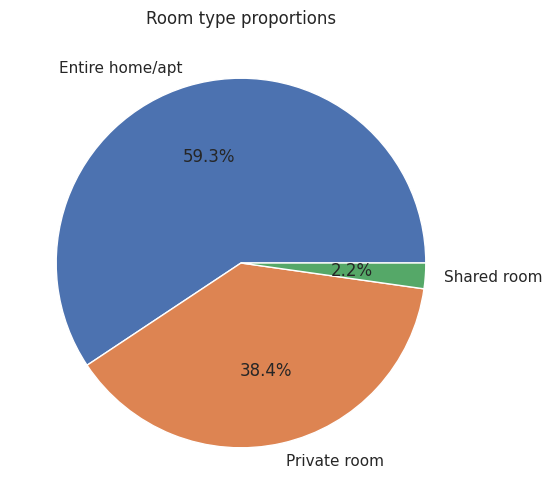

In [12]:
# Room type proportions
if 'room_type' in df.columns:
    plt.figure()
    df['room_type'].value_counts().plot.pie(autopct='%1.1f%%')
    plt.ylabel('')
    plt.title('Room type proportions')
    plt.show()


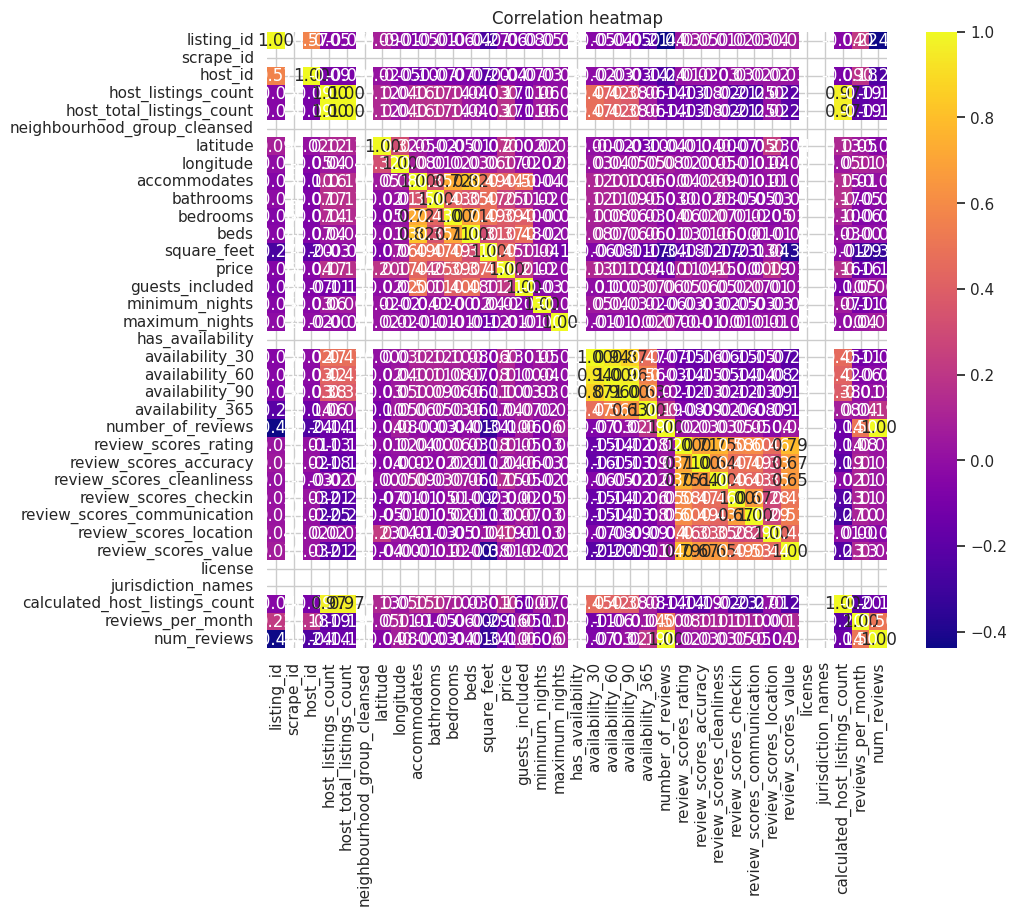

In [13]:
# Correlation heatmap for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='plasma')
    plt.title('Correlation heatmap')
    plt.show()

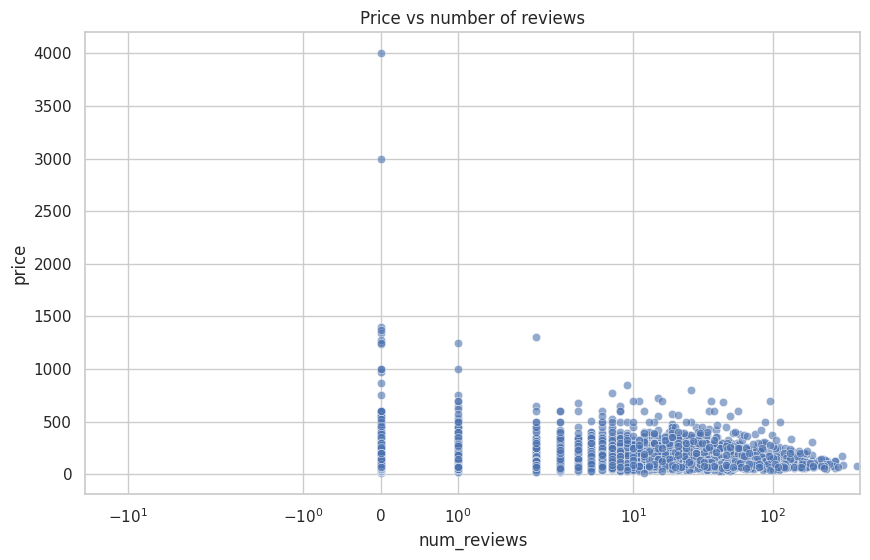

In [14]:

# Price vs number of reviews scatter
if 'price' in df.columns and 'num_reviews' in df.columns:
    plt.figure()
    sns.scatterplot(data=df, x='num_reviews', y='price', alpha=0.6)
    plt.xscale('symlog')
    plt.title('Price vs number of reviews')
    plt.show()


Using numeric cols: ['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'num_reviews']
Using categorical cols: ['neighbourhood_cleansed', 'room_type', 'property_type', 'bed_type']
RMSE: 27432.688, R2: 0.213


/tmp/ipython-input-205525852.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vals, y=top_feats, palette='magma')


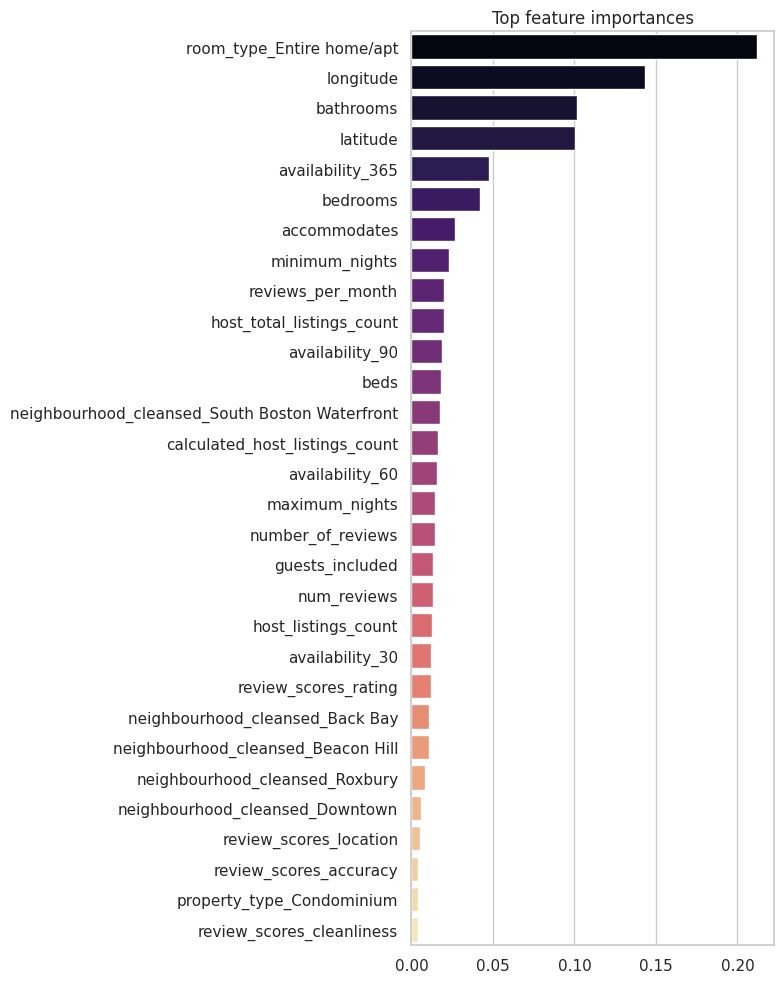

Saved feature importance to /content/drive/MyDrive/Harish_Intern/figs/feature_importance.png


In [15]:
# Improved preprocessing, modeling, and feature importance
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = Path(r'/content/drive/MyDrive/Harish_Intern/Boston Airbnb Open Data')
FIG_DIR = Path(r'/content/drive/MyDrive/Harish_Intern/figs')
FIG_DIR.mkdir(parents=True, exist_ok=True)
cleaned = DATA_DIR / 'cleaned_listings.csv'
df = pd.read_csv(cleaned)

# Select features
target = 'price'
# sensible categorical candidates
cat_cols = [c for c in ['neighbourhood_cleansed','room_type','property_type','bed_type'] if c in df.columns]
num_cols = df.select_dtypes(include=[np.number]).columns.drop([c for c in ['listing_id','id','host_id','scrape_id'] if c in df.columns], errors='ignore').tolist()
# remove target from numeric features if present
if target in num_cols:
    num_cols.remove(target)
# drop columns with too many missing values (>70%)
valid_num = [c for c in num_cols if df[c].notna().mean() > 0.3]
num_cols = valid_num

print('Using numeric cols:', num_cols)
print('Using categorical cols:', cat_cols)

# Pipelines
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),( 'onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)], remainder='drop')

# Prepare data
model_df = df[df[target].notna()].copy()
X = model_df[num_cols + cat_cols]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([('pre', preprocessor), ('est', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])
model.fit(X_train, y_train)
pred = model.predict(X_test)
rmse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f'RMSE: {rmse:.3f}, R2: {r2:.3f}')

# Save model and metrics
joblib.dump(model, Path(r'/content/drive/MyDrive/Harish_Intern/model_rf_pipeline.joblib'))
with open(Path(r'/content/drive/MyDrive/Harish_Intern/model_pipeline_metrics.txt'), 'w') as f:
    f.write(f'RMSE: {rmse:.3f}\nR2: {r2:.3f}\n')

# Feature importance: get feature names after preprocessing
pre = model.named_steps['pre']
est = model.named_steps['est']

feature_names = []
for name, trans, cols in pre.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        if isinstance(cols, str):
            cols = [cols]
        feature_names.extend(trans.get_feature_names_out(cols))
    else:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            # Handle OneHotEncoder manually if get_feature_names_out is not available
            ohe = trans.named_steps['onehot']
            for i, col in enumerate(cols):
                for category in ohe.categories_[i]:
                    feature_names.append(f'{col}_{category}')

fi = est.feature_importances_
# take top 30 for plotting
idx = np.argsort(fi)[-30:][::-1]
top_feats = np.array(feature_names)[idx]
top_vals = fi[idx]
plt.figure(figsize=(8,10))
sns.barplot(x=top_vals, y=top_feats, palette='magma')
plt.title('Top feature importances')
plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_importance.png')
plt.show()
print('Saved feature importance to', FIG_DIR / 'feature_importance.png')